In [184]:
import pickle as pic
import numpy as np
import seaborn as sb
import nltk, string
import pandas as pd
from gensim import corpora, models, similarities
from collections import defaultdict
from nltk.corpus import stopwords
import gensim
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import matplotlib
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [129]:
all_data = pic.load(open("../Data/all_data.p"))

In [130]:
all_data.head()

,song_id,title,artist,artist_id,ref_id,classification,fragment,is_description,annotator_id,ann_id,...,ann_lda_8,ann_lda_9,ann_lda_10,ann_lda_11,ann_lda_12,ref_lda_1,ref_lda_2,ref_lda_3,ref_lda_4,ref_lda_5
0,156640,0 to 100 / The Catch Up,Drake,130,3272685,accepted,"Maybe I'm searchin' for the problems, askin' w...",False,58812,3272685.0,...,0.000000,0.000000,0.000000,0.282126,0.000000,0.082925,0.014476,0.361812,0.141942,0.398844
1,156640,0 to 100 / The Catch Up,Drake,130,3272333,accepted,"The other night, Lavish Lee told me that I'm a...",False,658401,3272333.0,...,0.698166,0.053402,0.000000,0.190453,0.040434,0.018556,0.018324,0.261866,0.682717,0.018537
2,156640,0 to 100 / The Catch Up,Drake,130,3272181,accepted,[Bridge]\n Whole squad on that real shit\n Who...,False,18490,3272181.0,...,0.420995,0.011905,0.011905,0.459955,0.011905,0.014470,0.014494,0.942059,0.014595,0.014381
3,156640,0 to 100 / The Catch Up,Drake,130,3272064,accepted,"Fuck all that ""Drake you gotta chill"" shit\n I...",False,314816,3272064.0,...,0.000000,0.000000,0.000000,0.248440,0.000000,0.301521,0.018426,0.642951,0.018516,0.018585
4,156640,0 to 100 / The Catch Up,Drake,130,3272003,accepted,"I'm just here for the bucks and the billis, ni...",False,104344,3272003.0,...,0.000000,0.000000,0.000000,0.310252,0.000000,0.020452,0.020173,0.688751,0.250295,0.020329


## User Features

In [131]:
# Create users df with the count of referents
ref_count = all_data.groupby('annotator_id').size().reset_index()
users = ref_count
users.rename(columns={0 : "num_of_refs"}, inplace=True)
users.tail()


,annotator_id,num_of_refs
20682,3959029,1
20683,3962423,1
20684,3963270,1
20685,3974522,1
20686,3978034,1


In [132]:
# Add Voter Statistics
vote_group = all_data.groupby('annotator_id')['votes_total']
vote_info = vote_group.agg([sum, min, max, np.mean, np.median])
vote_info = vote_info.reset_index(drop=True)
vote_columns = {
    "sum": "vote_total",
    "min": "vote_min",
    "max": "vote_max",
    "median": "vote_median",
    "mean": "vote_avg"
}
vote_info.rename(columns=vote_columns, inplace=True)
users = pd.concat([users, vote_info], axis=1)
users.shape

(20687, 7)

In [ ]:
# Visualizations

In [133]:
# Add Comment Statistics
comment_group = all_data.groupby('annotator_id')['comment_count']
comment_info = comment_group.agg([sum, min, max, np.mean, np.median])
comment_info = comment_info.reset_index(drop=True)
comment_columns = {
    "sum": "comment_total",
    "min": "comment_min",
    "max": "comment_max",
    "median": "comment_median",
    "mean": "comment_avg"
}
comment_info.rename(columns=comment_columns, inplace=True)
users = pd.concat([users, comment_info], axis=1)
users.shape

(20687, 12)

In [ ]:
# Visualizations

In [134]:
# Add Annotation Character Statistics
all_data['ann_length_char'] = all_data['ann_text'].apply(lambda x: len(x))

ann_char_group = all_data.groupby('annotator_id')['ann_length_char']
ann_char_info = ann_char_group.agg([sum, min, max, np.mean, np.median])
ann_char_info = ann_char_info.reset_index(drop=True)
ann_char_columns = {
    "sum": "ann_char_total",
    "min": "ann_char_min",
    "max": "ann_char_max",
    "median": "ann_char_median",
    "mean": "ann_char_avg"
}
ann_char_info.rename(columns=ann_char_columns, inplace=True)
users = pd.concat([users, ann_char_info], axis=1)
users.shape


(20687, 17)

In [ ]:
# Visualizations

In [135]:
# Add Annotation Word Statistics
all_data['ann_length_word'] = all_data['ann_text'].apply(lambda x: len(x.split()))
ann_word_group = all_data.groupby('annotator_id')['ann_length_word']
ann_word_info = ann_word_group.agg([sum, min, max, np.mean, np.median])
ann_word_info = ann_word_info.reset_index(drop=True)
ann_word_columns = {
    "sum": "ann_word_total",
    "min": "ann_word_min",
    "max": "ann_word_max",
    "median": "ann_word_median",
    "mean": "ann_word_avg"
}
ann_word_info.rename(columns=ann_word_columns, inplace=True)
users = pd.concat([users, ann_word_info], axis=1)
users.shape

(20687, 22)

In [ ]:
# Visualizations

In [136]:
# Add Average Annotation LDA Per User Features
ann_lda_cols = [col for col in all_data.columns if col.startswith('ann_lda')]
for col in ann_lda_cols:
    col_group = all_data.groupby('annotator_id')[col]
    col_av = col_group.mean().reset_index(drop=True)
    users["user_%s" % col] = col_av

In [ ]:
# Visualizations

## Create Referent-User Pair Data

In [190]:
# Create Referent-User Pair Data
start = time.time()
refs_users_1 = generate_sample_df(.05, 3)
print refs_users_1.shape
print time.time() - start

KeyboardInterrupt: 

In [198]:
# Create Referent-User Pair Data
start = time.time()
refs_users_2 = generate_sample_df(.05, 5)
print refs_users_2.shape
print time.time() - start

(44103, 67)
0.000354051589966


In [199]:
# Create Referent-User Pair Data
start = time.time()
refs_users_3 = generate_sample_df(.05, 10)
print refs_users_3.shape
print time.time() - start

(80910, 67)
789.066133022


In [266]:
# Add Lyrics-User Interaction Features
add_interaction_features(refs_users_1)
print "Finished 1"
# add_interaction_features(refs_users_2)
print "Finished 2"
# add_interaction_features(refs_users_3)
print "Finished 3"

Finished 1


KeyboardInterrupt: 

In [267]:
refs_users_1

,song_id,title,artist,artist_id,ref_id,classification,fragment,is_description,annotator_id,ann_id,...,user_ann_lda_8,user_ann_lda_9,user_ann_lda_10,user_ann_lda_11,user_ann_lda_12,match,user_ann_in_song,user_ann_in_artist,user_votes_in_song,user_votes_in_artist
0,128497,"Bitch, Don't Kill My Vibe (Remix)",Kendrick Lamar,1421,1582952,accepted,"Don't cry to me dummy, you're a lightweight\n ...",False,85295,1582952.0,...,0.154189,0.006357,0.006357,0.067197,0.025715,1,1,0,8.0,8.0
1,385,Small Thing To a Giant,Gudda Gudda,270,15064,accepted,"C4ing, we blowing\n Up you better be detouring...",False,124,15064.0,...,0.063845,0.055483,0.034157,0.100135,0.073636,1,26,0,-2.0,-2.0
2,201,Ain't No Fun (If the Homies Can't Have None),Snoop Dogg,46,7589,accepted,Hit the switches,False,19,7589.0,...,0.064805,0.041370,0.025360,0.126608,0.108137,1,11,0,102.0,102.0
3,499561,Mockingbird traduction française,Eminem,45,4892390,unreviewed,Et tout a s'est pass quand papa est all en Cal...,False,1510885,4892390.0,...,0.001205,0.867432,0.009501,0.026908,0.015602,1,10,0,0.0,1.0
4,353431,Out My Face,Young Thug,20503,2990565,unreviewed,I just went platinum like a fuckin' nickel,False,706658,2990565.0,...,0.143345,0.000000,0.000000,0.458332,0.000000,1,2,0,0.0,0.0
5,56568,Bang Bang,Lil Wayne,4,2667321,accepted,"Even my ho about it, and don't doubt it\n Caus...",False,346222,2667321.0,...,0.069760,0.043200,0.020765,0.075102,0.031611,1,16,0,0.0,587.0
6,50214,Racks (Remix),YC,11240,211067,accepted,"Everywhere you look, you see YC",False,7576,211067.0,...,0.082893,0.035646,0.022055,0.091329,0.008091,1,3,0,4.0,4.0
7,17434,Fame,DMX,77,504278,accepted,It gets so dark (what?) the pain's so intense\...,False,16455,504278.0,...,0.142406,0.031035,0.004768,0.162833,0.028353,1,4,0,5.0,20.0
8,213179,FuckWitMeYouKnowIGotIt,Lil Wayne,4,2165953,accepted,I mean its simple\n Cant fuck wit us,False,181907,2165953.0,...,0.000000,0.079482,0.012281,0.000000,0.051837,1,2,0,5.0,5.0
9,200058,Appearance on Real Time with Bill Maher,Jay Z,2,8142161,accepted,I feel like a lot of this record is about the ...,False,1299009,8142161.0,...,0.101694,0.046192,0.018642,0.148217,0.056483,1,9,0,0.0,1426.0


In [257]:
# Create Target and Predictor
drop_cols = [col for col in refs_users_1.columns if col.startswith('ann_lda')]
drop_cols += ['song_id', 'title', 'artist', 'artist_id', 'ref_id', 'classification', 'fragment', 'annotator_id', 
              'ann_id', 'ann_text', 'has_voters', 'comment_count', 'votes_total', 'ann_length_char', 
              'ann_length_word']
X_1 = refs_users_1.drop(drop_cols, axis=1)
y_1 = refs_users_1['match']
X_2 = refs_users_2.drop(drop_cols, axis=1)
y_2 = refs_users_2['match']
X_3 = refs_users_3.drop(drop_cols, axis=1)
y_3 = refs_users_3['match']

In [ ]:
# Heatmap of Correlations

## XGBoost Classifier

In [258]:
predictors = [x for x in X_1.columns if x != 'match']
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

In [259]:
X_1.head().T

,0,1,2,3,4
is_description,False,False,False,False,False
ref_lda_1,0.0186085,0.0340373,0.0669194,0.0118109,0.0337333
ref_lda_2,0.0184768,0.033518,0.442092,0.880789,0.0339135
ref_lda_3,0.622347,0.365392,0.0681881,0.0120607,0.0341742
ref_lda_4,0.321886,0.217795,0.355149,0.0835093,0.460945
ref_lda_5,0.0186821,0.349257,0.0676512,0.0118306,0.437234
num_of_refs,13,700,136,45,2
vote_total,26,4278,1609,1,0
vote_min,0,-43,-5,0,0
vote_max,8,85,63,1,0


[0]	train-auc:0.527485+0.00514541	train-error:0.248904+0.00135354	test-auc:0.495859+0.00570587	test-error:0.253168+0.00412968
[10]	train-auc:0.969423+0.00133566	train-error:0.0698658+0.00098645	test-auc:0.96298+0.00307259	test-error:0.0730084+0.00323993
[20]	train-auc:0.972487+0.00118707	train-error:0.0695518+0.0012375	test-auc:0.964186+0.00299776	test-error:0.0724308+0.00407484
[30]	train-auc:0.975905+0.00103022	train-error:0.0685408+0.00102129	test-auc:0.965244+0.00255049	test-error:0.072091+0.00408759
[40]	train-auc:0.978479+0.000688463	train-error:0.0680738+0.00104282	test-auc:0.965506+0.00240739	test-error:0.0722268+0.00369555
[50]	train-auc:0.980718+0.000389252	train-error:0.0677+0.00091585	test-auc:0.966226+0.00262268	test-error:0.0717176+0.00417372
[60]	train-auc:0.982661+0.000222969	train-error:0.0670718+0.00087471	test-auc:0.966573+0.00241814	test-error:0.0717854+0.00391895

Model Report
Train Accuracy : 0.9341
Test Accuracy : 0.9273
AUC Score (Train): 0.984077
AUC Score (Tes

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=68, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

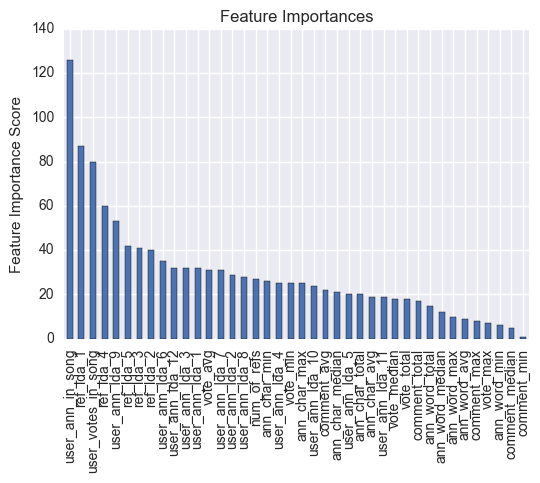

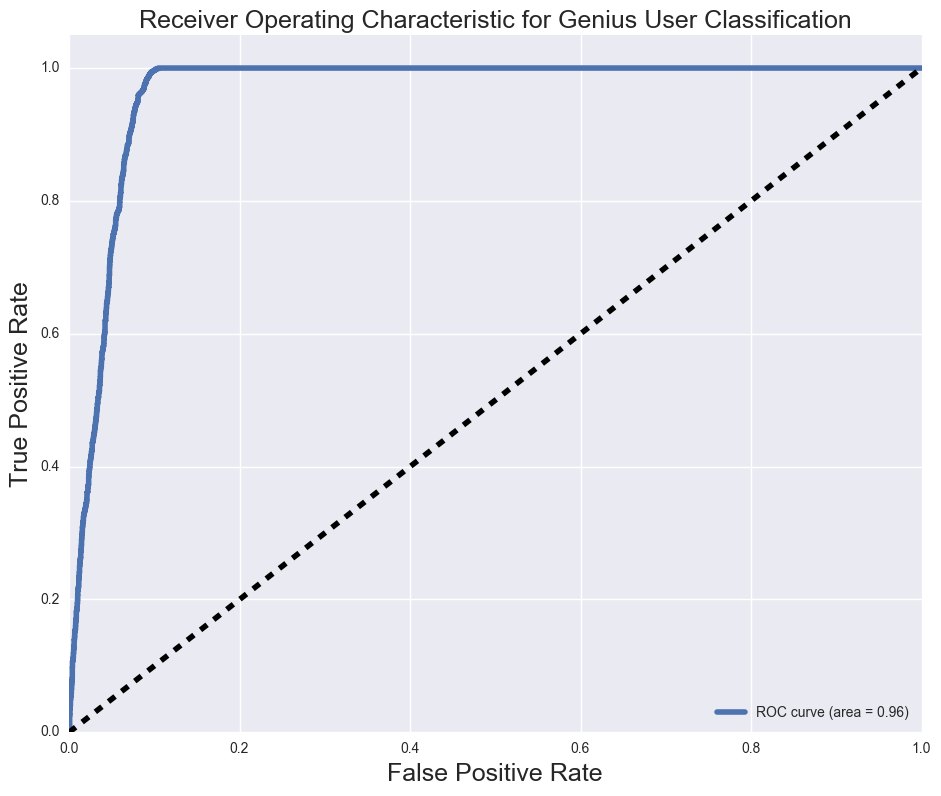

In [284]:
modelfit(xgb1, X_1, predictors, eval_metric='error')

[0]	train-auc:0.530125+0.00652132	test-auc:0.505735+0.00507879
[1]	train-auc:0.540693+0.00393347	test-auc:0.50636+0.00844806
[2]	train-auc:0.548517+0.0046737	test-auc:0.510353+0.00635751
[3]	train-auc:0.556474+0.00409933	test-auc:0.509749+0.0065239
[4]	train-auc:0.5653+0.00701638	test-auc:0.507284+0.00919491

Model Report
Accuracy : 0.8331
AUC Score (Train): 0.549826
             precision    recall  f1-score   support

          0       0.83      1.00      0.91     36739
          1       1.00      0.00      0.00      7364

avg / total       0.86      0.83      0.76     44103



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=5, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

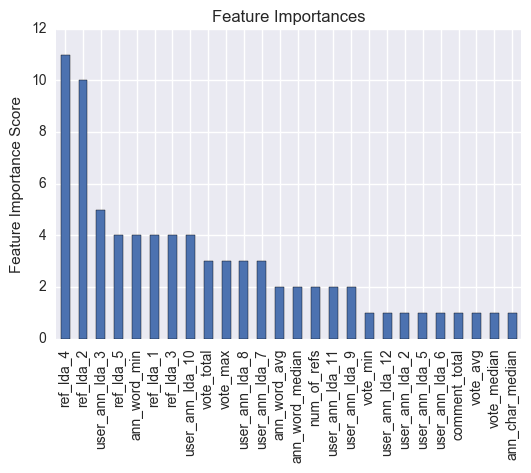

In [218]:
modelfit(xgb1, X_2, predictors)

[0]	train-auc:0.500698+0.00125725	train-error:0.0910148+0.000794337	test-auc:0.49998+2.68507e-05	test-error:0.0910148+0.00317757
[1]	train-auc:0.508999+0.011539	train-error:0.0910148+0.000794337	test-auc:0.498935+0.00373794	test-error:0.0910148+0.00317757
[2]	train-auc:0.51371+0.0112199	train-error:0.0910148+0.000794337	test-auc:0.498259+0.00432898	test-error:0.0910148+0.00317757
[3]	train-auc:0.522298+0.00773421	train-error:0.0910148+0.000794337	test-auc:0.498935+0.00691521	test-error:0.0910148+0.00317757
[4]	train-auc:0.5288+0.00729046	train-error:0.0910148+0.000794337	test-auc:0.498529+0.00925158	test-error:0.0910148+0.00317757

Model Report
Accuracy : 0.909
AUC Score (Train): 0.527036
             precision    recall  f1-score   support

          0       0.91      1.00      0.95     73546
          1       0.00      0.00      0.00      7364

avg / total       0.83      0.91      0.87     80910



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=5, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

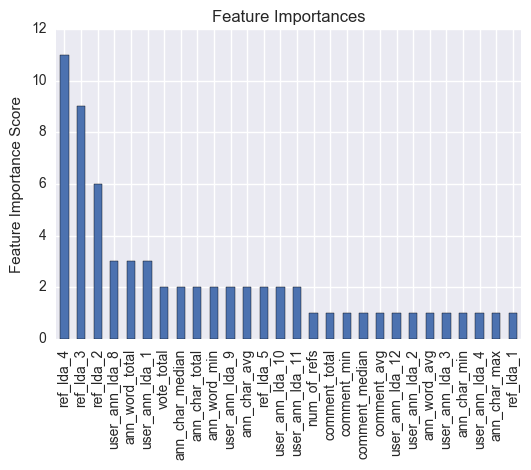

In [225]:
modelfit(xgb1, X_3, predictors)

In [ ]:
# Tune parameters of the best result

In [269]:
   X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_1[predictors], X_1['match'], 
                                                                         stratify=X_1['match'])

In [274]:
y_test.shape

(7360,)

## Functions

In [283]:
def generate_sample_df(pos_samples, neg_samples_ratio=10, by='artist'):
    # Get Positive Samples
    sample_df = all_data.sample(frac=pos_samples)
    
    # Merge User Information
    sample_df = pd.merge(sample_df, users, how='left', on='annotator_id')
    
    # Create Label
    sample_df['match'] = 1
    
    # Generate Negative Samples By Artist
    if by == 'artist':
        samp_list = zip(sample_df['annotator_id'], sample_df['artist_id'], sample_df['ref_id'])
        for user, artist, ref in samp_list:
            mask = (all_data['artist_id'] == artist) & (all_data['annotator_id'] != user)
            artist_df = all_data[mask]
            if artist_df.empty:
                continue            
            elif neg_samples_ratio > artist_df.shape[0]:
                    neg_sample = artist_df
            else:
                neg_sample = artist_df.sample(n=neg_samples_ratio)            
            neg_sample['annotator_id'] = user
            neg_sample_df = pd.merge(neg_sample, users, how='left', on='annotator_id')
            neg_sample_df['match'] = 0
            sample_df = sample_df.append(neg_sample_df)

    # Generate Negative Samples By Song
    elif by == 'song':
        samp_list = zip(sample_df['annotator_id'], sample_df['song_id'], sample_df['ref_id'])
        for user, artist, ref in samp_list:
            mask = (all_data['song_id'] == artist) & (all_data['annotator_id'] != user)
            song_df = all_data[mask]
            if song_df.empty:
                continue
            elif neg_samples_ratio > song_df.shape[0]:
                    neg_sample = song_df.sample(n=song_df.shape[0])
            else:
                neg_sample = song_df.sample(n=neg_samples_ratio)
            neg_sample['annotator_id'] = user
            neg_sample_df = pd.merge(neg_sample, users, how='left', on='annotator_id')
            neg_sample_df['match'] = 0
            sample_df = sample_df.append(neg_sample_df)
    return sample_df


user_song_group = all_data.groupby(['annotator_id', 'song_id']).size()
def user_ann_in_song(annotator_id, song_id):
    try:
        result = user_song_group[annotator_id][song_id]
    except KeyError:
        result = 0
    return result


user_artist_group = all_data.groupby(['annotator_id', 'song_id']).size()
def user_ann_in_artist(annotator_id, artist_id):
    try:
        result = user_artist_group[annotator_id][artist_id]
    except KeyError:
        result = 0
    return result


user_song_vote_group = all_data.groupby(['annotator_id', 'song_id'])['votes_total'].sum()
def user_votes_in_song(annotator_id, song_id):
    try:
        result = user_song_vote_group[annotator_id][song_id]
    except KeyError:
        result = 0
    return result


user_artist_vote_group = all_data.groupby(['annotator_id', 'artist_id'])['votes_total'].sum()
def user_votes_in_artist(annotator_id, artist_id):
    try:
        result = user_artist_vote_group[annotator_id][artist_id]
    except KeyError:
        result = 0
    return result


def add_interaction_features(df):
    df['user_ann_in_song'] = refs_users_1.apply(lambda x: user_ann_in_song(x['annotator_id'], x['song_id']), axis=1)
    df['user_ann_in_artist'] = refs_users_1.apply(lambda x: user_ann_in_artist(x['annotator_id'], x['artist_id']), axis=1)
    df['user_votes_in_song'] = refs_users_1.apply(lambda x: user_votes_in_song(x['annotator_id'], x['song_id']), axis=1)
    df['user_votes_in_artist'] = refs_users_1.apply(lambda x: user_votes_in_artist(x['annotator_id'], x['artist_id']), axis=1)

    
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, eval_metric='error'):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['match'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['error', 'auc'], early_stopping_rounds=early_stopping_rounds, verbose_eval=10)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Train-test-split
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(dtrain[predictors], dtrain['match'], 
                                                                         stratify=dtrain['match'])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric=eval_metric)
        
    #Predictions:
    dtrain_predictions_train = alg.predict(X_train)
    dtrain_predictions_test = alg.predict(X_test)
    dtrain_predprob_train = alg.predict_proba(X_train)[:,1]
    dtrain_predprob_test = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Train Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions_train)
    print "Test Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions_test)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob_train)
    print "AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtrain_predprob_test)
    print metrics.classification_report(y_test, dtrain_predictions_test)
     
    # Plot Feature Importance    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig('../Images/feat_imp.png')
    
    # Plot Roc Curve
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = metrics.roc_curve(y_test, dtrain_predprob_test)
    ROC_AUC[1] = metrics.auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver Operating Characteristic for Genius User Classification', fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig('../Images/ROC.png')
    return alg

